In [ ]:
df <- arrow::read_parquet(here("data", "featurefull.parquet") ) %>% relocate(starts_with("winner"), starts_with("looser"), starts_with("match"), starts_with("tournament"))
df %>% glimpse()

relocate: columns reordered (winner.name, winner.id, winner.rank, winner.bornAt, winner.height, …)



Rows: 17,926
Columns: 69
$ winner.name                     <chr> "Shuichi Sekiguchi", "Shuichi Sekiguch…
$ winner.id                       <chr> "sl92", "sl92", "sl92", "sl92", "tf58"…
$ winner.rank                     <int> 399, 399, 399, 399, 619, 619, 619, 619…
$ winner.bornAt                   <chr> "USA", "USA", "USA", "USA", "Japan", "…
$ winner.height                   <dbl> 168, 168, 168, 168, 170, 170, 170, 170…
$ winner.Anwins                   <dbl> 5, 5, 5, 5, 6, 6, 6, 6, 18, 18, 11, 11…
$ winner.Anlosses                 <dbl> 10, 10, 10, 10, 4, 4, 4, 4, 15, 15, 5,…
$ winner.Anjogos                  <dbl> 15, 15, 15, 15, 10, 10, 10, 10, 33, 33…
$ winner.Awinrate                 <dbl> 33.33333, 33.33333, 33.33333, 33.33333…
$ winner.nwins                    <dbl> 353, 353, 353, 353, 166, 166, 166, 166…
$ winner.nlosses                  <dbl> 248, 248, 248, 248, 141, 141, 141, 141…
$ winner.njogos                   <dbl> 601, 601, 601, 601, 307, 307, 307, 307…
$ winner.winrat

In [ ]:
# vfold
set.seed(1)
df.folds <- vfold_cv(df, v = 5, repeats = 5) # no strata
df.folds %>% glimpse()

Rows: 25
Columns: 3
$ splits <list> [<vfold_split[14340 x 3586 x 17926 x 69]>], [<vfold_split[1434…
$ id     <chr> "Repeat1", "Repeat1", "Repeat1", "Repeat1", "Repeat1", "Repeat2…
$ id2    <chr> "Fold1", "Fold2", "Fold3", "Fold4", "Fold5", "Fold1", "Fold2", …


# Feature Selection

Algumas das nossas características são relações diretas de outras características, o que pode levar a problemas de multicolinariedade; portanto, vamos ter que escolher entre essas variáveis. Para isso, vamos ajustar vários modelos para cada conjunto de varíaveis de cada grupo, passo a passo, escolhendo o conjunto de cada grupo com melhor performance. Nesta secção vamos usar regressão logística, pela sua simplicidade.

Nota: aqui, players indica 2 colunas, uma de winner e outra de looser
* Rank:
    * players.rank
    * match.diffRank
    * match.avgRank
* Born:
    * players.bornAt
    * players.bornAt, players.bornAt.tournFreq
    * players.bornAt, players.bornAt.hasTourn
    * players.bornAt.tournFreq
    * players.bornAt.hasTourn
    * players.bornAt, match.playersBorn.hasTournXor
    * match.playersBorn.hasTournXor
    * players.bornAt, match.playersBorn.tournFreqDiff
    * match.playersBorn.tournFreqDiff
* Altura:
    * players.height
    * players.heightF
    * players.heightFC
    * match.diffHeights
    * match.avgHeights
    * match.heightFCvs
* Nº de jogos
    * players.nwins
    * players.nlosses
    * players.njogos
    * players.winrate, players.jogos
    * players.winrate
    * match.njogosDiff
* Nº de jogos total
    * Será a mesma variável da de cima só que estrapulado, mas é preciso 
* numero do torneio do jogador
    * player.nTournament
    * match.nTournamentDiff
* delay do torneio dos jogadores
    * player.lastTournamentDelay
* Mão dominante dos jogadores
    * match.domHands
* backhands dos jogadores
    * match.backhand
    * match.backHandsL1
    * match.backHandsL2
* ronda do tourneio
    * tournament.round
* se jogo teve tie breaker
    * match.hadTieBreaker
* terreno do torneio
    * tournament.ground
* duracao do torneio
    * tournament.duration
    * tournament.durationF
    * tournament.durationFL
* data do torneio num ano
    * tournament.quarter
    * tournament.quarterL1
    * tournament.quarterL2
    * tournament.month
* data do torneio
    * tournament.dateDistance
* recompensa do torneio
    * tournament.prize
    * tournament.smallPrize



In [ ]:
df.featureSelect.model <- workflow() %>%
    add_model(logistic_reg())
df.metrics <- metric_set(accuracy, f_meas, roc_auc, pr_auc)
df.featureSelect.model

══ Workflow ══════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: None
Model: logistic_reg()

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Logistic Regression Model Specification (classification)

Computational engine: glm 


In [ ]:
library(formulaic) # add_formula(match.sets ~ .)
vars <- c(# variables with no direct correlation
    "winner.lastTournamentDelayW",
    "looser.lastTournamentDelayW",
    "match.domHands",
    "match.tournamentRound",
    "match.hadTieBreaker", 
    "tournament.dateDistance"
)
form <- create.formula(input.names = vars, outcome.name = "match.setsCount", dat = df)
print(form$formula)
print(form$inclusion.table$include.variable)

match.setsCount ~ winner.lastTournamentDelayW + looser.lastTournamentDelayW + 
    match.domHands + match.tournamentRound + match.hadTieBreaker + 
    tournament.dateDistance
<environment: 0x0000024332db4728>
[1] TRUE TRUE TRUE TRUE TRUE TRUE


In [ ]:
# primeiro modelo
library(tictoc)
tic()
df.featureSelect.model %>% add_formula(form$formula) %>% fit_resamples(df.folds, metrics = df.metrics, control = control_grid(save_pred = TRUE)) -> df.featureSelect.firstModel
toc(log=T)
collect_metrics(df.featureSelect.firstModel)

6.16 sec elapsed


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6765143,25,0.001659724,Preprocessor1_Model1
f_meas,binary,0.7796199,25,0.001374097,Preprocessor1_Model1
pr_auc,binary,0.7238419,25,0.002138314,Preprocessor1_Model1
roc_auc,binary,0.6125514,25,0.001584453,Preprocessor1_Model1


Setting levels: control = 2, case = 3

Setting direction: controls > cases



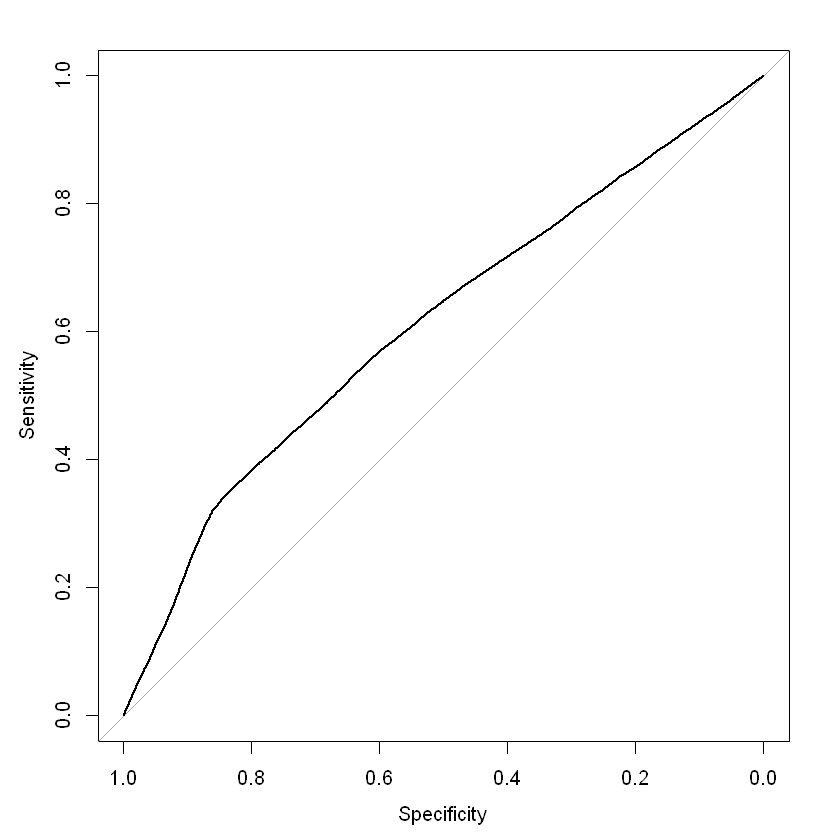

In [ ]:
# curva roc do primeiro
pred <- collect_predictions(df.featureSelect.firstModel)
pred %>% pROC::roc(match.setsCount, .pred_2) %>% plot()

In [ ]:
install.packages("pROC")

Installing package into 'C:/Users/Plancha/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'pROC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Plancha\AppData\Local\Temp\RtmpQrCpx8\downloaded_packages


In [ ]:
featuresFit <- function(formula){
    df.featureSelect.model %>% add_formula(formula$formula) %>% fit_resamples(df.folds, metrics = df.metrics) -> fitted
    collect_metrics(fitted)
}